In [2]:
import torch
import torch.nn as nn
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torchsummary import summary

# This is to test if the model is working(fwd pass)

In [ ]:
from models.UVixLSTM_SelfAtt import UVixLSTM_noAtt
from models.HoVerNet.HoVerNet import HoVerNet
from models.UniverSeg.model import universeg
sample_input = torch.randn(8, 3, 256, 256)  
model = universeg()

summary(model, input_size=(3, 256, 256))
# output = model(sample_input)

# print("Output keys:", output.shape)

In [3]:
from models.UVixLSTM_SelfAtt import UVixLSTM_noAtt
from models.HoVerNet.HoVerNet import HoVerNet
model = HoVerNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, input_size=(3, 256, 256))

# output = model(sample_input)

# print("Output keys:", output['np'].shape)

input image shape torch.Size([2, 3, 256, 256])
after conv0 torch.Size([2, 64, 250, 250])
after downsample 0 torch.Size([2, 256, 262, 262])
d0 shape: torch.Size([2, 256, 262, 262])
d1 shape: torch.Size([2, 512, 142, 142])
d2 shape: torch.Size([2, 1024, 82, 82])
d3 shape: torch.Size([2, 1024, 52, 52])
UpSample2x input shape: torch.Size([2, 1024, 52, 52])
UpSample2x output shape: torch.Size([2, 1024, 104, 104])
Target shape for interpolation: torch.Size([2, 1024, 82, 82])
UpSample2x input shape: torch.Size([2, 512, 46, 46])
UpSample2x output shape: torch.Size([2, 512, 92, 92])
Target shape for interpolation: torch.Size([2, 512, 70, 70])
UpSample2x input shape: torch.Size([2, 256, 50, 50])
UpSample2x output shape: torch.Size([2, 256, 100, 100])
Target shape for interpolation: torch.Size([2, 256, 78, 78])
UpSample2x input shape: torch.Size([2, 1024, 52, 52])
UpSample2x output shape: torch.Size([2, 1024, 104, 104])
Target shape for interpolation: torch.Size([2, 1024, 82, 82])
UpSample2x inpu

# This is inspecting the dictionary being fed to the model

In [3]:
try:
    data = np.load('./Data/pannuke_6c.npy', allow_pickle=True)
    print("Data loaded successfully!")
    print("Keys in data:", data.keys())  # If it's a dictionary
    # If it's an array, you can directly check its shape:
    print("Shape of data:", data.shape) 
except EOFError as e:
    print("EOFError:", e)
except ValueError as e:
    print("ValueError:", e)
except Exception as e:
    print("An error occurred:", e)


Data loaded successfully!
An error occurred: 'numpy.ndarray' object has no attribute 'keys'


In [5]:
import numpy as np

# Load the data dictionary
data = np.load('./Data/pannuke_6c_augs.npy', allow_pickle=True).item()

# Print the length of each key's value
for key, value in data.items():
    if isinstance(value, list):
        print(f"Key: {key}, Length: {len(value)}")
    else:
        print(f"Key: {key}, Value: Not a list (type: {type(value)})")

Key: original_image, Length: 5179
Key: mask, Length: 5179
Key: aug_images, Length: 400
Key: aug_masks, Length: 400
Key: all_images, Length: 5579
Key: all_masks, Length: 5579
Key: train_patched_images, Length: 4742
Key: train_patched_masks, Length: 4742
Key: val_patched_images, Length: 446
Key: val_patched_masks, Length: 446
Key: test_patched_images, Length: 391
Key: test_patched_masks, Length: 391


In [25]:
data['test_patched_images'][1].shape

(256, 256, 3)

# Visualizing any images and masks

4742


/tmp/ipykernel_269476/1836377635.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Ensure tight layout without extra padding


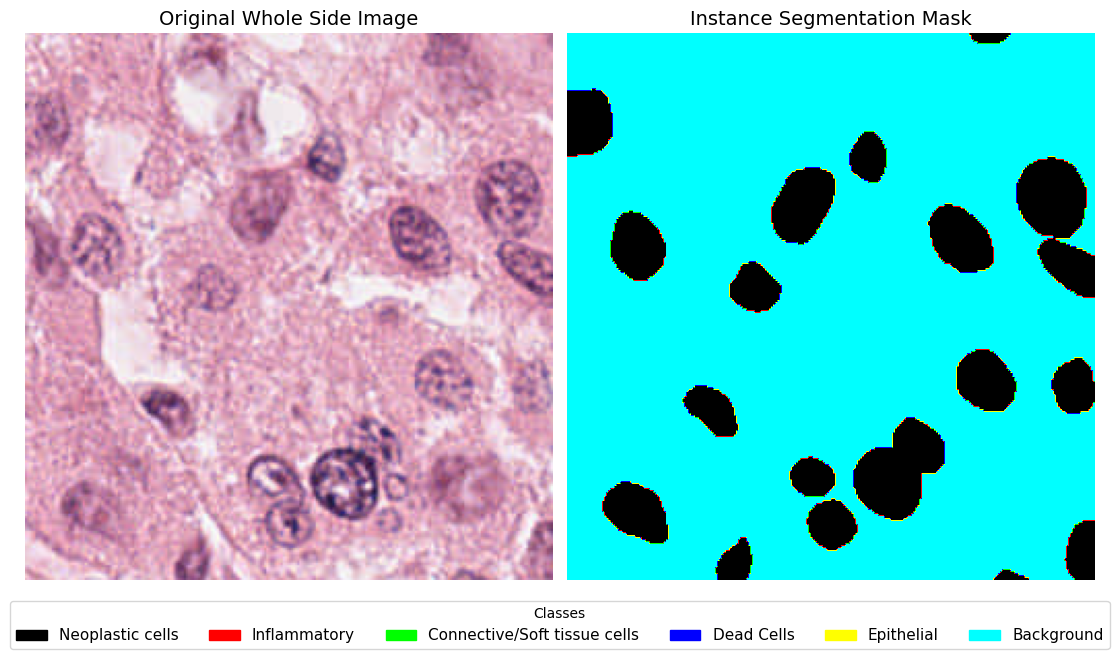

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

num = 4402
data = np.load('./Data/pannuke_6c_augs.npy', allow_pickle=True).item()

train_patched_images = data.get('train_patched_images', [])
train_patched_masks = data.get('train_patched_masks', [])
colors = [
    (0, 0, 0),         # Class 0 - Black
    (1, 0, 0),         # Class 1 - Red
    (0, 1, 0),         # Class 2 - Green
    (0, 0, 1),         # Class 3 - Blue
    (1, 1, 0),         # Class 4 - Yellow
    (0, 1, 1),         # Class 5 - Cyan
]
cmap = plt.cm.colors.ListedColormap(colors)

if train_patched_images and train_patched_masks:
    print(len(train_patched_images))
    first_image = train_patched_images[num]
    first_mask = train_patched_masks[num]
    
    single_channel_mask = np.argmax(first_mask, axis=-1)  # Create a single channel mask

    fig, axes = plt.subplots(1, 2, figsize=(11, 6))  # 1 row, 2 columns

    axes[0].imshow(first_image, cmap='gray', aspect='auto')
    axes[0].set_title('Original Whole Side Image', fontsize=14)
    axes[0].axis('off')
    axes[0].grid(False)

    # Display the first mask with color mapping
    im = axes[1].imshow(single_channel_mask, cmap=cmap, aspect='auto')
    axes[1].set_title('Instance Segmentation Mask', fontsize=14)
    axes[1].axis('off')
    axes[1].grid(False)

    # Create a legend
    legend_labels = ['Neoplastic cells', 'Inflammatory', 'Connective/Soft tissue cells', 
                    'Dead Cells', 'Epithelial', 'Background']
    legend_patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(colors))]

    # Add a new axes for the legend at the bottom
    legend_ax = fig.add_axes([0.2, -0.1, 0.6, 0.1])  # Adjust these values for position and size
    legend_ax.axis('off')  # Turn off the axes
    legend_ax.legend(handles=legend_patches, loc='center', ncol=6, title='Classes', fontsize=11)

    # Adjust layout to minimize whitespace
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.2)  # Adjust these values as needed
    plt.tight_layout()  # Ensure tight layout without extra padding

    plt.show()

else:
    print("No images or masks found under the keys 'train_patched_images' or 'train_patched_masks'.")

In [64]:
print(len(train_patched_images))

2257


In [5]:
data = np.load('./Data/pannuke_fold1_0255_try-.npy', allow_pickle=True).item()

# Get the train patched images
train_patched_images = data.get('train_patched_images', [])
train_patched_masks = data.get('train_patched_masks', [])

In [6]:
train_patched_masks[1]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

DOWNLOAD IMAGES FROM PATHML NPY

In [ ]:
file_path = '/mnt/data2/sohum/datasets/panuke/Fold_2s'
for file in os.listdir(file_path):
    print(file)